In [19]:
import os
import tensorflow as tf 
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow.keras.layers.experimental import preprocessing 
from IPython.display import clear_output
import matplotlib.pyplot as plt
import PIL
import PIL.Image
import numpy as np
from tqdm import tqdm

In [20]:
#tf.config.run_functions_eagerly(True)

In [21]:
train_text_file = "VOCtrainval_11-May-2012/VOCdevkit/VOC2012/ImageSets/Segmentation/train.txt"
val_text_file = "VOCtrainval_11-May-2012/VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt"
image_folder = "VOCtrainval_11-May-2012/VOCdevkit/VOC2012/JPEGImages"
mask_folder = "VOCtrainval_11-May-2012/VOCdevkit/VOC2012/SegmentationClass"

In [22]:
def read_paths_img_masks(text_file_path, image_path, mask_path):
    paths = []
    with open(text_file_path, "r") as file:
        file_names = file.readlines()
    for file_name in tqdm(file_names):
        image = os.path.join(image_path, file_name.strip() + ".jpg")
        mask = os.path.join(mask_path, file_name.strip() + ".png")
        paths.append((image, mask))
    return paths


In [23]:

train_paths = read_paths_img_masks(train_text_file, image_folder, mask_folder)
val_paths = read_paths_img_masks(val_text_file, image_folder, mask_folder)

#train_paths = tf.data.Dataset.from_tensors(train_paths)
#val_paths = tf.data.Dataset.from_tensors(val_paths)


100%|██████████| 1449/1449 [00:00<00:00, 295241.51it/s]


In [24]:
num_classes = 3


def Create_Mask(Img):
    Seg_Labels = np.zeros(
        (Img.shape[0], Img.shape[1], num_classes), dtype=np.float16)
    for class_ in range(num_classes):
        Seg_Labels[:, :, class_] = (Img == class_)
    return tf.cast(Seg_Labels, dtype=tf.float16)


def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    #input_mask -= 1
    return input_image, input_mask


def load_image_to_array(file_path):
    img = tf.keras.preprocessing.image.load_img(file_path)
    return tf.keras.preprocessing.image.img_to_array(img)


def load_image_and_mask(paths_tuple):
    inp_img = load_image_to_array(paths_tuple[0])
    mask_img = load_image_to_array(paths_tuple[1])
    input_image = tf.image.resize(inp_img, (128, 128))
    input_mask = tf.image.resize(mask_img, (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return [input_image, input_mask]


In [25]:
def load_dataset(paths):
    imgs_and_masks = []
    for path in tqdm(paths):
        #print("Processing: ", path)
        imgs_and_masks.append(load_image_and_mask(path))
        
    return imgs_and_masks


In [26]:
print("Loading Training Dataset...")
train_images = load_dataset(train_paths)
print("Loading Validation Dataset...")
test_images = load_dataset(val_paths)

train_images[0][1].shape


Loading Training Dataset...


100%|██████████| 1464/1464 [00:13<00:00, 106.26it/s]


Loading Validation Dataset...


100%|██████████| 1449/1449 [00:12<00:00, 114.86it/s]


TensorShape([128, 128, 3])

In [27]:
train_images_ds = tf.data.Dataset.from_tensor_slices(train_images)
test_images_ds = tf.data.Dataset.from_tensor_slices(test_images)

def mapToDataset(inp):
    return inp[0], inp[1]

train_images_ds = train_images_ds.map(mapToDataset)
test_images_ds = test_images_ds.map(mapToDataset)

In [28]:
TRAIN_LENGTH = len(train_images_ds)
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [29]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same randomn changes.
    self.augment_inputs = preprocessing.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = preprocessing.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [30]:
train_batches = (
    train_images_ds
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images_ds.batch(BATCH_SIZE)

In [31]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

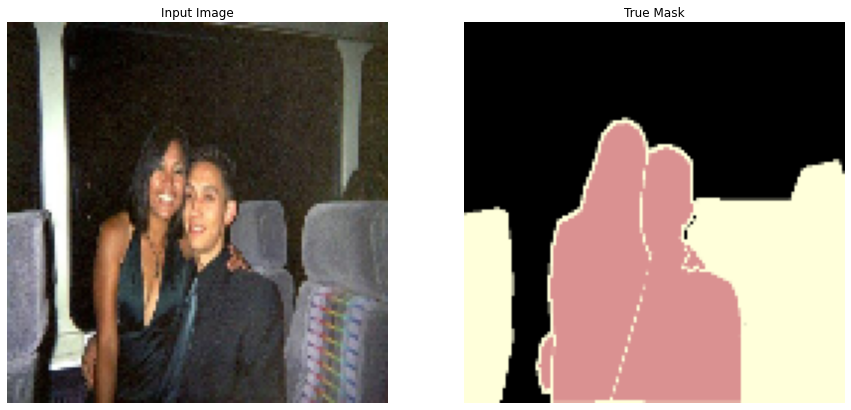

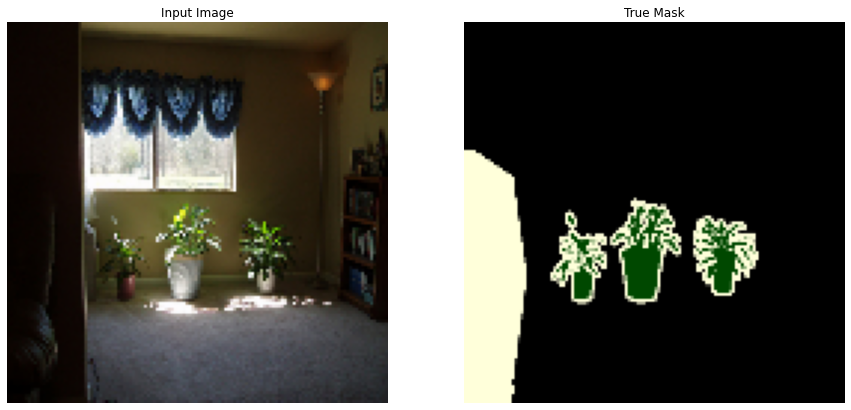

2021-10-02 09:24:48.313118: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [32]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [33]:
arr = sample_mask.numpy()
test = arr[arr != -1]
test.shape

(49152,)

(281, 500)


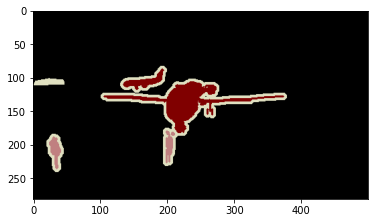

In [34]:
path = os.path.join("VOCtrainval_11-May-2012/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png")
with open(path, "rb") as f:
    img = PIL.Image.open(f) 
    plt.imshow(img)
    nparr = np.asarray(img)
    print(nparr.shape)

In [35]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [36]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [37]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [38]:
OUTPUT_CLASSES = 21

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [39]:
tf.keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [40]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [41]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

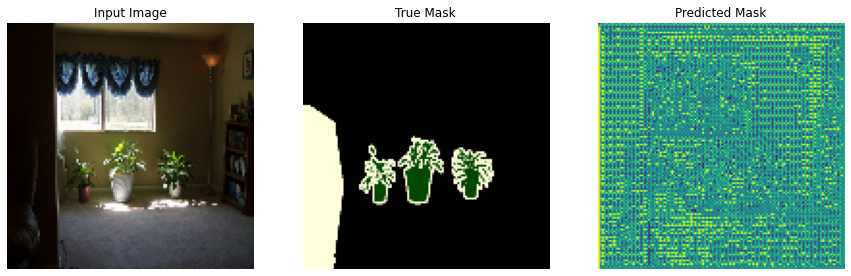

In [42]:
show_predictions()

In [43]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [44]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 5#len(train_images)//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

Epoch 1/20


InvalidArgumentError:  logits and labels must have the same first dimension, got logits shape [1048576,21] and labels shape [3145728]
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at var/folders/t3/t_6hg0q576vbv5hbdh1zdckw0000gn/T/ipykernel_3680/3718291970.py:9) ]] [Op:__inference_train_function_101258]

Function call stack:
train_function


In [ ]:
print(128 * 128 * 3)